# 变分量子特征求解器（VQE）

<em> Copyright (c) 2020 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

- 在这个案例中，我们将展示如何通过Paddle Quantum训练量子神经网络来求解量子系统的能量基态。

- 首先，让我们通过下面几行代码引入必要的library和package。

In [1]:
import os
import numpy
import platform
import matplotlib.pyplot as plt

from numpy import concatenate
from numpy import pi as PI
from numpy import savez, zeros
from IPython.display import clear_output
from paddle import fluid
from paddle.complex import matmul, transpose
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import pauli_str_to_matrix
from paddle_quantum.VQE.chemistrysub import H2_generator

## 背景

- 量子计算在近期非常有前景的一个应用就是变分量子特征求解器 (VQE, Variational Quantum Eigensolver) [1-3]。
- VQE作为量子化学在短期内含噪量子设备（NISQ device）上的核心应用之一, 其核心任务是求解一个量子尺度上物理系统的哈密顿量 $H$ 的基态能量及其对应的量子态。数学上，可以理解为求解一个厄米矩阵 (Hermitian matrix) 的最小特征值及其对应的特征向量。
- 接下来我们将通过一个简单的例子学习如何通过训练量子神经网络解决这个问题，我们的目标是通过训练量子神经网络去找到量子态 $\left| \phi  \right\rangle $ (可以理解为一个归一化的复数向量), 使得 $$\left\langle \phi  \right|H\left| \phi  \right\rangle =\lambda_{\min}(H)$$ 其中 $\left\langle \phi  \right|$ 是 $\left| \phi  \right\rangle$ 的共轭转置，$\lambda_{\min}(H)$是矩阵$H$的最小特征值。


## VQE分析氢分子的性质

- 对于具体需要分析的分子，我们需要其几何构型 (geometry)、电荷 (charge) 以及自旋多重度 (spin multiplicity) 等多项信息来建模获取描述系统的哈密顿量。具体的，通过我们内置的量子化学工具包可以利用 fermionic-to-qubit 映射的技术来输出目标分子的量子比特哈密顿量表示。
- 在这里，作为简单的入门案例，我们提供已经映射好的的氢分子的哈密顿量。 

In [2]:
Hamiltonian, N = H2_generator()

面向更高级的用户，我们这里提供一个简单的生成氢分子 (H2)哈密顿量的教程。先安装以下两个package (**仅Mac/Linux用户可使用，Windows用户暂时不支持**):


In [3]:
!pip install openfermion
clear_output()

In [4]:
!pip install openfermionpyscf
clear_output()


  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/cb/6e/01bc7d2e478ea75b9b5dd262c876f5e7d32105e713b588af5b0121def125/openfermionpyscf-0.4.tar.gz (13 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/c0/f1/fe52a94e92acf3fa8c5543d86cfed6fea0526011d2ff2dda352f9cf9eaef/pyscf-1.7.4.tar.gz (7.5 MB)


In [5]:
# 操作系统信息
sysStr = platform.system()

# 判断操作系统
if sysStr in ('Linux', 'Darwin'):

    import openfermion
    import openfermionpyscf

    # 请检查是否正确下载了 h2 的几何构型文件
    geo = 'h2.xyz'
    charge = 0
    multiplicity = 1

    # 生成哈密顿量
    mol = openfermion.hamiltonians.MolecularData(geo, 'sto-3g', multiplicity, charge)
    openfermionpyscf.run_pyscf(mol)
    terms_molecular_hamiltonian = mol.get_molecular_hamiltonian()
    fermionic_hamiltonian = openfermion.transforms.get_fermion_operator(terms_molecular_hamiltonian)
    qubit_op = openfermion.transforms.jordan_wigner(fermionic_hamiltonian)

    # 打印结果
    print("The generated h2 Hamiltonian is \n", qubit_op)

除了氢分子 (H2) 之外, 我们也提供了氟化氢 (HF) 分子的几何构型文件 `hf.xyz`。如果你需要测试更多分子的几何构型，请移步至这个[数据库](http://smart.sns.it/molecules/index.html)。此外，我们还需要把这些本质上由泡利算符表示的哈密顿量转化成 Paddle quantum 支持的数据格式，这里我们提供这个接口。

In [6]:
def Hamiltonian_str_convert(qubit_op):
    '''
    将上述提供的哈密顿量信息转为量桨支持的泡利字符串
    H = [[1.0, "z0,x1"], [-1.0, "y0,z1"], ...]
    '''
    info_dic = qubit_op.terms
    
    def process_tuple(tup):
        if len(tup) == 0:
            return 'i0'
        else:
            res = ''
            for ele in tup:
                res += ele[1].lower()
                res += str(ele[0])
                res += ','
            return res[:-1]
    H_info = []
    
    for key, value in qubit_op.terms.items():
        H_info.append([value.real, process_tuple(key)])
    
    return H_info

if sysStr in ('Linux', 'Darwin'):
    Hamiltonian = Hamiltonian_str_convert(qubit_op)

## 搭建量子神经网络（QNN）

- 在实现VQE的过程中，我们首先需要设计量子神经网络QNN（也可以理解为参数化量子电路）。这里，我们提供一个预设好的的深度为D层的4量子比特的量子电路模板，图中的虚线框内为一层：

![Utheta.jpg](https://release-data.cdn.bcebos.com/PIC%2FUtheta.jpg)

- 我们预设一些该参数化电路的参数，比如宽度为 $N = 4$ 量子位。

- 初始化其中的变量参数，${\bf{\theta }}$ 代表我们量子神经网络中的参数组成的向量。

接下来我们根据上图中的电路设计，通过 Paddle Quantum 的 `UAnsatz` 函数和内置的 `real_entangled_layer(theta, D)` 电路模板来高效搭建量子神经网络。 

In [7]:
def U_theta(theta, Hamiltonian, N, D):
    """
    Quantum Neural Network
    """
    
    # 按照量子比特数量/网络宽度初始化量子神经网络
    cir = UAnsatz(N)
    
    # 内置的 {R_y + CNOT} 电路模板
    cir.real_entangled_layer(theta[:D], D)
    
    # 铺上最后一列 R_y 旋转门
    for i in range(N):
        cir.ry(theta=theta[D][i][0], which_qubit=i)
        
    # 量子神经网络作用在默认的初始态 |0000>上
    cir.run_state_vector()
    
    # 计算给定哈密顿量的期望值
    expectation_val = cir.expecval(Hamiltonian)

    return expectation_val

## 配置训练模型 - 损失函数
- 现在我们已经有了数据和量子神经网络的架构，我们将进一步定义训练参数、模型和损失函数.
- 设置训练模型中的的损失函数。通过作用量子神经网络 $U(\theta)$ 在初始态 $|0..0\rangle$ 上，我们将得到输出态 $\left| {\psi \left( {\bf{\theta }} \right)} \right\rangle $。进一步，在VQE模型中的损失函数一般由量子态 $\left| {\psi \left( {\bf{\theta }} \right)} \right\rangle$ 关于哈密顿量 $H$ 的期望值 (能量期望值 expectation value) 给出，具体可定义为

$$
\mathcal{L}(\boldsymbol \theta) =  \left\langle {\psi \left( {\bf{\theta }} \right)} \right|H\left| {\psi \left( {\bf{\theta }} \right)} \right\rangle
$$

In [8]:
class StateNet(fluid.dygraph.Layer):
    """
    Construct the model net
    """

    def __init__(self, shape, param_attr=fluid.initializer.Uniform(low=0.0, high=2 * PI), dtype="float64"):
        super(StateNet, self).__init__()
        
        # 初始化 theta 参数列表，并用 [0, 2*pi] 的均匀分布来填充初始值
        self.theta = self.create_parameter(shape=shape, attr=param_attr, dtype=dtype, is_bias=False)
        
    # 定义损失函数和前向传播机制
    def forward(self, N, D):
        
        # 计算损失函数/期望值
        loss = U_theta(self.theta, Hamiltonian, N, D)

        return loss

## 配置训练模型 - 模型参数

在进行量子神经网络的训练之前，我们还需要进行一些训练的超参数设置，主要是学习速率 (LR, learning rate)、迭代次数(ITR, iteration)和量子神经网络计算模块的深度 (D, Depth)。这里我们设定学习速率为0.5, 迭代次数为50次。读者不妨自行调整来直观感受下超参数调整对训练效果的影响。

In [9]:
ITR = 80  # 设置训练的总迭代次数
LR = 0.2  # 设置学习速率
D = 2     # 设置量子神经网络中重复计算模块的深度 Depth

## 进行训练

- 当训练模型的各项参数都设置完成后，我们将数据转化为Paddle动态图中的变量，进而进行量子神经网络的训练。
- 过程中我们用的是Adam Optimizer，也可以调用Paddle中提供的其他优化器。
- 我们将训练过程中的结果存储在summary_data文件中。

In [10]:
# 初始化paddle动态图机制
with fluid.dygraph.guard():


    # 确定网络的参数维度
    net = StateNet(shape=[D + 1, N, 1])

    # 一般来说，我们利用Adam优化器来获得相对好的收敛，当然你可以改成SGD或者是RMS prop.
    opt = fluid.optimizer.AdamOptimizer(learning_rate=LR, parameter_list=net.parameters())

    # 记录优化结果
    summary_iter, summary_loss = [], []
    
    # 优化循环
    for itr in range(1, ITR + 1):
        
        # 前向传播计算损失函数
        loss = net(N, D)

        # 在动态图机制下，反向传播极小化损失函数
        loss.backward()
        opt.minimize(loss)
        net.clear_gradients()
        
        # 更新优化结果
        summary_loss.append(loss.numpy())
        summary_iter.append(itr)
        
        # 打印结果
        if itr % 20 == 0:
            print("iter:", itr, "loss:", "%.4f" % loss.numpy())
            print("iter:", itr, "Ground state energy:", "%.4f Ha" % loss.numpy())

    # 储存训练结果到 output 文件夹
    os.makedirs("output", exist_ok=True)
    savez("./output/summary_data", iter=summary_iter, energy=summary_loss)

iter: 20 loss: -1.0843
iter: 20 Ground state energy: -1.0843 Ha
iter: 40 loss: -1.1313
iter: 40 Ground state energy: -1.1313 Ha
iter: 60 loss: -1.1356
iter: 60 Ground state energy: -1.1356 Ha
iter: 80 loss: -1.1361
iter: 80 Ground state energy: -1.1361 Ha


## 测试效果
我们现在已经完成了量子神经网络的训练，得到的基态能量的估计值大致为-1.136 Ha (注: Ha为[哈特里能量](https://baike.baidu.com/item/%E5%93%88%E7%89%B9%E9%87%8C%E8%83%BD%E9%87%8F/13777793?fr=aladdin)，是原子单位制中的能量单位)，我们将通过与理论值的对比来测试效果。
- 训练后得到的QNN作用在初始零态上就是VQE算法的输出态，最后更新的损失函数则为其对应的能量。
- 接下来我们将训练QNN得到的基态能量和理想情况下的理论值。
- 我们可以先求解理论值，即哈密顿量$H$的最小特征值。

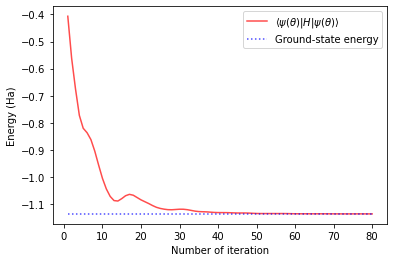

In [11]:
result = numpy.load('./output/summary_data.npz')

eig_val, eig_state = numpy.linalg.eig(pauli_str_to_matrix(Hamiltonian, N))
min_eig_H = numpy.min(eig_val.real)
min_loss = numpy.ones([len(result['iter'])]) * min_eig_H

plt.figure(1)
func1, = plt.plot(result['iter'], result['energy'], alpha=0.7, marker='', linestyle="-", color='r')
func_min, = plt.plot(result['iter'], min_loss, alpha=0.7, marker='', linestyle=":", color='b')
plt.xlabel('Number of iteration')
plt.ylabel('Energy (Ha)')

plt.legend(handles=[
    func1,
    func_min
],
    labels=[
        r'$\left\langle {\psi \left( {\theta } \right)} '
        r'\right|H\left| {\psi \left( {\theta } \right)} \right\rangle $',
        'Ground-state energy',
    ], loc='best')

#plt.savefig("vqe.png", bbox_inches='tight', dpi=300)
plt.show()


## 参考文献

[1] [Peruzzo, A. et al. A variational eigenvalue solver on a photonic quantum processor. Nat. Commun. 5, 4213 (2014).](https://www.nature.com/articles/ncomms5213)

[2] [McArdle, S., Endo, S., Aspuru-Guzik, A., Benjamin, S. C. & Yuan, X. Quantum computational chemistry. Rev. Mod. Phys. 92, 015003 (2020).](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.92.015003)

[3] [Cao, Y. et al. Quantum chemistry in the age of quantum computing. Chem. Rev. 119, 10856–10915 (2019).](https://pubs.acs.org/doi/abs/10.1021/acs.chemrev.8b00803)
